# GHDL module tests

These tests focus on the GHDL module correctly inferring VHDL code to a hardware model. They also might integrate external Verilog code. The yosys synthesis changes the hardware description model into a net list of inferred silicon elements and writes out Verilog code, which can be verified in its functionality against an expected output according to a stimulus.

The following code generates a schematic elaborating on the the data flow and involvement of the installed tools:

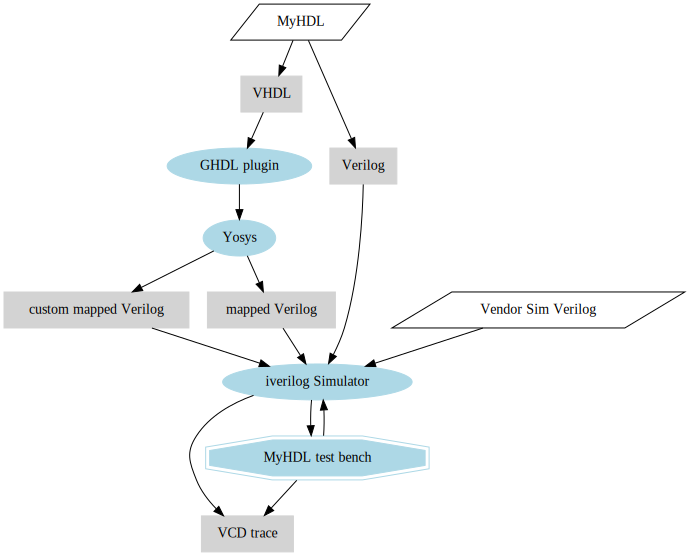

In [1]:
from graphviz import Digraph
dot = Digraph("Schematic")
dot.attr('node', shape='parallelogram')
dot.node('A', 'MyHDL' ); dot.node('V', 'Vendor Sim Verilog'); 
dot.attr('node', shape='box', style='filled', color='lightgrey')
dot.node('M', 'custom mapped Verilog'); dot.node('t', 'VCD trace'); 

dot.node('B', 'VHDL'); dot.node('C', 'Verilog'); dot.node('m', 'mapped Verilog')

dot.attr('node', shape='ellipse', color='lightblue')
dot.node("G", "GHDL plugin")
dot.node('Y', 'Yosys' );  dot.node('I', 'iverilog Simulator')
dot.attr('node', shape='doubleoctagon')

dot.node('T', 'MyHDL test bench');
dot.edges(['AB', 'AC', 'BG', 'GY', 'Ym', 'YM', 'CI', 'VI', 'mI', 'MI', 'It', 'TI', 'IT', 'Tt'])
dot

All boxed items above represent readable source code or data, when filled gray, they are generated. The Co-Simulation framework allows us to implement different work flows 'embedded' in a Python hardware object which takes care of generation and wrapping of the simulation, driving and verifying the model. The *MyHDL test bench* is the central element stimulating the hardware model. Both the testbench and the iverilog Simulator can write out a `.vcd` trace which can be verified with the GTKwave waveform viewer.

## Post-Synthesis Cosimulation test of FIFO buffer implementation

This test verifies if the VHDL synthesis step produces the correct results for a FIFO buffer implementation which consists of:

* The fifo buffer state machine in VHDL [fifobuf.vhdl](/edit/work/examples/vhdl/fifobuf.vhdl)
* A Block RAM implementation in Verilog [bram.v](/edit/work/examples/verilog/bram.v)

In [2]:
import sys
sys.path.append("../examples")

ECP5_LIB = "lib/techlibs/ecp5"
LIBFILES = [ ECP5_LIB + "/cells_sim.v", "-I", ECP5_LIB]
LIBFILES += [ ECP5_LIB + "/gsr_pur_assign.v" ]
EXAMPLES_PREFIX = "../examples"

### Cosimulation test bench

Normally, the Cosimulation TB would be generated when inferring a MyHDL module. Here we have added it manually
for the VHDL only module:

[tb_fifobuffer.v](/edit/work/tests/verilog/tb_fifobuffer.v)

This file actually generates a `fifobuf.vcd` trace during cosimulation.


**Note**: This test is currently expected to fail with a `Data mismatch` error when `ADDR_W > 7` (this leads to inference of a `DP16KD` primitive on ECP5).
This is due to model discrepancies between the current yosys internal library mapping and the 'next generation' TDP memory concept and might be resolved later on.

In [3]:
from ivl_cosim import *
from myhdl import *

SYNTH_CMD = "synth_ecp5 -top FifoBuffer; show -format ps -prefix fifobuf *"
DEBUG = False

@block
def fifobuf_mapped(wren, idata, iready, odata, oready, rden, err, reset, clk):
    """When inferring this entity, a cosimulation object is generated which
    includes necessary modules"""
    
    sigs = locals()
    name = "fifobuffer"
    pathname = EXAMPLES_PREFIX + "/vhdl/fifobuf.vhdl"
    mapped = name + "_mapped"

    map_cmd = ['yosys', '-Q', '-m', 'ghdl', '-p', \
        """ghdl -gADDR_W=7 -gDATA_W=8 %s -e %s;
            read_verilog %s/verilog/bram.v;
            %s ;
            write_verilog %s.v
        """ % (pathname, name, EXAMPLES_PREFIX, SYNTH_CMD, mapped)]
    
    if DEBUG:
        child = subprocess.Popen(map_cmd, stdout = subprocess.PIPE, stderr = subprocess.PIPE)

        c = child.communicate()
        print("==== YOSYS stdout ====")
        print(c[0].decode('utf8'))
        try:
            msg = c[1].decode('utf8')
            print("==== YOSYS stderr ====")
            print(msg)
        except:
            print("==== stderr failed ====")
    else:
        child = subprocess.call(map_cmd)


    params = { }

    options = { 'name' : mapped, 'tbname' : name, 'libfiles' : LIBFILES} 
    return setupCosimulationIcarus(options, params, sigs, "", "verilog/")

@block
def clkgen(clk, DELAY):
    @always(delay(DELAY))
    def clkgen():
        clk.next = not clk

    return instances()

@block
def fifobuf_tb():
    err = Signal(bool(0))
    clk = Signal(0)
    reset = Signal(bool(0))
    idata, odata = [ Signal(intbv()[8:]) for i in range(2) ]
    iready, oready = [ Signal(bool()) for i in range(2) ]
    rden, wren = [ Signal(bool()) for i in range(2) ]

    # inst_fifobuf = fifobuffer(wren, idata, iready, odata, oready, rden, err, reset, clk)
    inst_fifobuf = fifobuf_mapped(wren, idata, iready, odata, oready, rden, err, reset, clk)

    inst_clkgen = clkgen(clk, 20)

    count = Signal(intbv()[8:])

    @instance
    def testbench_fill():
        rden.next = 0
        wren.next = 0
        reset.next = 1
        yield delay(20)
        reset.next = 0

        yield delay(20)

        for d in [ 0xde, 0xad, 0xbe, 0xef, 0xff, 0x20 ]:
            idata.next = d
            yield clk.negedge
            wren.next = 1
            yield clk.negedge
            wren.next = 0
            yield clk.posedge
            if iready == 0:
                raise ValueError("not ready")

        yield delay(100)
        if count != 6:
            raise ValueError("Didn't get data")

    @instance
    def testbench_drain():
        yield oready.posedge

        for d in [ 0xde, 0xad, 0xbe, 0xef, 0xff, 0x20 ]:
            while oready == 1:
                yield clk.negedge
                rden.next = 1
                yield clk.negedge
                rden.next = 0
                yield clk.posedge
                print("Data", odata)
                if odata != d:
                    for _ in range(5):
                        yield clk.posedge
                    raise ValueError("Data mismatch")
                count.next = count + 1
            yield delay(10)

        print("PASSED")
        raise StopSimulation

    return instances()

def test_fifobuf():
    tb = fifobuf_tb()
    tb.config_sim(backend = 'myhdl')
    tb.run_sim()
    tb.quit_sim()


test_fifobuf()

['iverilog', '-s', 'tb_fifobuffer', '-D', 'mixed_hdl', '-o', 'fifobuffer_mapped.o', 'fifobuffer_mapped.v', 'verilog/tb_fifobuffer.v', 'lib/techlibs/ecp5/cells_sim.v', '-I', 'lib/techlibs/ecp5', 'lib/techlibs/ecp5/gsr_pur_assign.v']
Data de
Data ad
Data be
Data ef
Data ff
Data 20
PASSED


Download [fifobuf.vcd](fifobuf.vcd) to analyze the trace.